In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import calendar
import itertools as it
import statsmodels.api as sm
#import statsmodels.formula.api  as sm
import time

C:\Users\dstackma\.julia\v0.6\Conda\deps\usr\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


0.07998019270640322 0.06849391843236538 1.167697724658285
0.07872664232856938 0.1320532572222274 0.5961734226372266


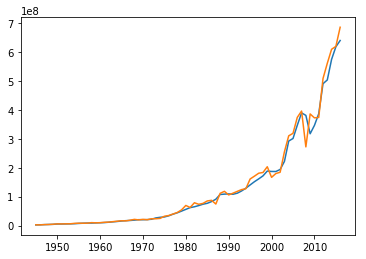

In [207]:
# Set path load data
cpath = 'C:\Users\dstackma\Dropbox\Problem sets\D Stackman\Empirical Asset Pricing'
crsp = pd.read_csv(cpath + '/crsp_nyse_retns_1945m1_2016m12.csv')

# convert crsp dates pd datetime
crsp['date'] = pd.to_datetime(crsp['DATE'], format="%Y%m%d")
crsp['year'] = crsp['date'].dt.year

# compute monthly dividends
crsp['div'] = (crsp['vwretd']-crsp['vwretx'])*crsp['totval'].shift()

# monthly log returns
crsp['retn'] = np.log(1 + crsp['vwretd'])

# collapse to annual 
prc  = crsp[['year','totval']].groupby('year')[['totval']].last().reset_index()
retn = crsp[['year','retn']].groupby('year')[['retn']].sum().reset_index()
cash = crsp[['year','div']].groupby('year')[['div']].sum().reset_index()

# merge
crsp_ann = pd.merge(prc, retn, how='left', on='year')
crsp_ann = pd.merge(crsp_ann, cash, how='left', on='year')
crsp_ann['div_mkt'] = np.empty(crsp_ann['year'].shape)

# compute dividends from reinvesting in NYSE
crsp.loc[0,'div'] = 0
for t, r in crsp.iterrows():
    tau = np.int(np.floor(t/12.))
    
    # if it's January
    if (t%12) == 0:    
        crsp_ann.loc[ tau, 'div_mkt']= crsp['div'][t]
       # print tau, t, crsp['div'][t]
        
    else:
        crsp_ann.loc[ tau, 'div_mkt']= (crsp['div'][t] + 
                crsp_ann.loc[ tau, 'div_mkt']*(1+crsp['vwretd'][t-1]) )

# rename columns
crsp_ann = crsp_ann.rename(index=str, columns={"totval" : "price", "div" : "div_cash"})

# compute log price dividend ratios and dividend growth rates
crsp_ann['pd_cash'] = np.log(crsp_ann['price']/crsp_ann['div_cash'])
crsp_ann['pd_mkt']  = np.log(crsp_ann['price']/crsp_ann['div_mkt'])
crsp_ann['dg_cash'] = np.log(crsp_ann['div_cash']).diff()
crsp_ann['dg_mkt']  = np.log(crsp_ann['div_mkt']).diff()
        
# report mean and volatility of dividend growth for both cash and mkt
print np.mean(crsp_ann['dg_cash']), np.std(crsp_ann['dg_cash']), np.mean(crsp_ann['dg_cash'])/np.std(crsp_ann['dg_cash'])
print np.mean(crsp_ann['dg_mkt']),  np.std(crsp_ann['dg_mkt']),  np.mean(crsp_ann['dg_mkt'])/np.std(crsp_ann['dg_mkt']) 

# explain the difference
# ... explanation ...

# Plot the two dividend series
plt.plot(crsp_ann['year'],crsp_ann['div_cash'])
plt.plot(crsp_ann['year'],crsp_ann['div_mkt'])
plt.show()

In [314]:
# lag values of lhs variables
crsp_ann['retn_'] = crsp_ann['retn'].shift(-1) 
crsp_ann['divg_'] = crsp_ann['dg_cash'].shift(-1)
crsp_ann['pd_cash_'] = crsp_ann['pd_cash'].shift(-1) 

#crsp_ann.head()

# run predictive regressions
retn_results = sm.ols('retn_ ~ pd_cash', data=crsp_ann).fit()
print(retn_results.summary2())
divg_results = sm.ols('divg_ ~ pd_cash', data=crsp_ann).fit()
print(divg_results.summary2())

# predictive regressions 1945:1990
crsp_ann_4590 = crsp_ann[(crsp_ann['year']>=1945) & (crsp_ann['year']<=1990)] 
retn4590_results = sm.ols('retn_ ~ pd_cash', data=crsp_ann_4590).fit()
print(retn4590_results.summary2())
divg4590_results = sm.ols('divg_ ~ pd_cash', data=crsp_ann_4590).fit()
print(divg4590_results.summary2())

# predictive regressions 1990:2016
crsp_ann_9016 = crsp_ann[(crsp_ann['year']>=1990) & (crsp_ann['year']<=2016)] 
retn9016_results = sm.ols('retn_ ~ pd_cash', data=crsp_ann_9016).fit()
print(retn9016_results.summary2())
divg9016_results = sm.ols('divg_ ~ pd_cash', data=crsp_ann_9016).fit()
print(divg9016_results.summary2())

# explain the differences
# ... explanation ...

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.086   
Dependent Variable: retn_            AIC:                -59.1888
Date:               2018-02-09 12:17 BIC:                -54.6634
No. Observations:   71               Log-Likelihood:     31.594  
Df Model:           1                F-statistic:        7.567   
Df Residuals:       69               Prob (F-statistic): 0.00759 
R-squared:          0.099            Scale:              0.024741
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      0.5321    0.1579   3.3695  0.0012   0.2171   0.8472
pd_cash       -0.1228    0.0446  -2.7509  0.0076  -0.2118  -0.0337
-----------------------------------------------------------------
Omnibus:              10.797       Durbin-Watson:          2.076 
Prob(Omnibus):        

In [315]:
# Campell-Shiller variance decomposition

# run predictive regressions
pd_results = sm.ols('pd_cash_ ~ pd_cash', data=crsp_ann).fit()
print(pd_results.summary2())

# predictive regressions 1945:1990
pd4590_results = sm.ols('pd_cash_ ~ pd_cash', data=crsp_ann_4590).fit()
print(pd4590_results.summary2())

# predictive regressions 1990:2016
pd9016_results = sm.ols('pd_cash_ ~ pd_cash', data=crsp_ann_9016).fit()
print(pd9016_results.summary2())


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.818   
Dependent Variable: pd_cash_         AIC:                -39.6730
Date:               2018-02-09 12:17 BIC:                -35.1476
No. Observations:   71               Log-Likelihood:     21.836  
Df Model:           1                F-statistic:        315.4   
Df Residuals:       69               Prob (F-statistic): 1.95e-27
R-squared:          0.820            Scale:              0.032568
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
Intercept   0.3258     0.1812    1.7981   0.0765   -0.0357   0.6873
pd_cash     0.9092     0.0512   17.7583   0.0000    0.8070   1.0113
-----------------------------------------------------------------
Omnibus:               1.469        Durbin-Watson:          2.086
Prob(Omnibus):   

-0.005557922882557557 -0.10971787762397872


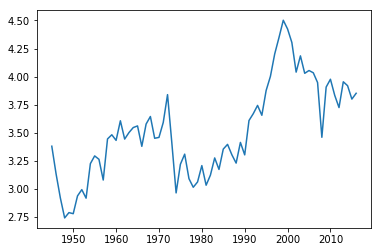

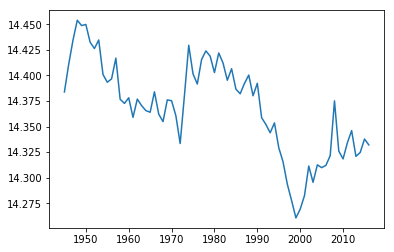

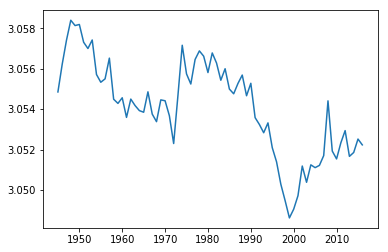

In [312]:
# Using estimated regression coefficients...
a_r = retn_results.params[0];
b_r = retn_results.params[1];
a_d = divg_results.params[0];
b_d = divg_results.params[1];

# Approximation requires constant rho = 1-D/P
rho= 1-np.mean(crsp_ann['div_cash']/crsp_ann['price']);

# Compute `NPV' of expected retns, divg: vector method
T = crsp_ann['pd_cash'].shape[0];
retn_npv = np.empty(T);
divg_npv = np.empty(T);
S = 200; # approx infinity with 200

t0 = time.clock() # Time it!
for t in range(T):
    pt  = crsp_ann['pd_cash'][t]
    ceR = 0.;
    ceD = 0.;
    for s in range(1,S):
        eR  = a_r*sum(np.power(np.tile(b_r,s),range(s))) + pt*np.power(b_r,s)
        ceR+= np.power(rho,s-1)*eR
        eD  = a_d*sum(np.power(np.tile(b_d,s),range(s))) + pt*np.power(b_d,s)
        ceD+= np.power(rho,s-1)*eD
    
    retn_npv[t] = ceR
    divg_npv[t] = ceD

# Print time elapsed
#print time.clock()-t0    

# Add derived series to dataframe
crsp_ann['retn_npv'] = retn_npv;
crsp_ann['divg_npv'] = divg_npv;

# Print variance decomposition
vcv_retn_pd = np.cov(crsp_ann['retn_npv'],crsp_ann['pd_cash']);
vcv_divg_pd = np.cov(crsp_ann['divg_npv'],crsp_ann['pd_cash']);
print vcv_divg_pd[0,1]/vcv_divg_pd[1,1],vcv_retn_pd[0,1]/vcv_retn_pd[1,1]

# Plot derived series
plt.plot(crsp_ann['year'],crsp_ann['pd_cash'])
plt.show()
plt.plot(crsp_ann['year'],retn_npv)
plt.show()
plt.plot(crsp_ann['year'],divg_npv)
plt.show()

In [309]:
# Simulate returns and pd ratios from estimated system (`45-`90)
a_rt = retn4590_results.params[0];
b_rt = retn4590_results.params[1];
a_pd = pd4590_results.params[0];
b_pd = pd4590_results.params[1];


0.0996182133485007 -0.005587980759800124 0.5321384227989507 -0.12275250597141885


In [305]:
rmat1 = np.random.normal(0,1,4);
rmat2 = np.random.normal(0,1,4);

print np.cov(rmat1,rmat2)
print np.cov(rmat1,rmat2)[1,1]

[[ 1.41854611 -1.05464959]
 [-1.05464959  1.14383664]]
1.1438366370345108


ValueError: endog and exog matrices are different sizes

In [366]:
np.ones([6,5]).transpose()

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

In [171]:
div_df.head()

,year,div,div_mktwt
0,1945,2.189254e+06,1.915637e+06
1,1946,2.599130e+06,2.797160e+06
2,1947,3.231866e+06,3.144116e+06
3,1948,3.757384e+06,3.867839e+06
4,1949,4.139718e+06,3.709899e+06


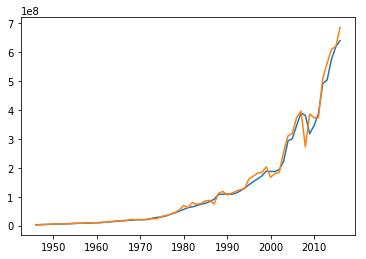

In [172]:

plt.plot(div_ann['year'],div_ann['div_cash'])
plt.plot(div_ann['year'],div_ann['div_mkt'])
plt.show()

In [211]:
print 1-np.mean(crsp['div']/crsp['totval'])
print 1-np.mean(crsp_ann['div_cash']/crsp_ann['price'])
print 1/(1+np.mean(crsp['div']/crsp['totval']))
print 1/(1+np.mean(crsp_ann['div_cash']/crsp_ann['price']))

0.99719428937924
0.9678117439949462
0.9972021393665348
0.9688155180822983


0.253553716746


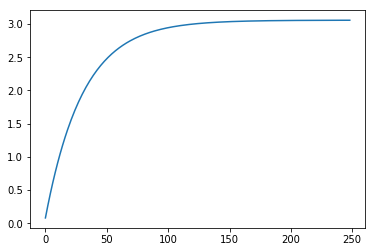

0.0443131512866


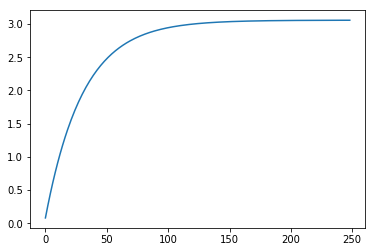

In [284]:
#aa =  0.5321; # retns
#bb = -0.1228; # retns
aa =  0.0996; # div growth  
bb = -0.0056; # div growth    
p0 = 3.38;
T  = 250;
rho= 1-np.mean(crsp_ann['div_cash']/crsp_ann['price']);
MM = 2;

# loop method
t0 = time.clock()
NPV= np.empty(T-1)
for m in range(MM):
    ceR= 0.;
    for s in range(1,T):
        eR = 0.;
        for r in range(s):
            eR+=aa*np.power(bb,r)

        eR+= p0*np.power(bb,s)
        ceR+= np.power(rho,s-1)*eR
        NPV[s-1]=ceR;
    
print time.clock()-t0    

plt.plot(range(T-1),NPV)
plt.show()

# vector method
t0 = time.clock()
NPV= np.empty(T-1)
for m in range(MM):
    eR = 0.;
    ceR= 0.;
    for s in range(1,T):
        eR = aa*sum(np.power(np.tile(bb,s),range(s))) + p0*np.power(bb,s)
        ceR+= np.power(rho,s-1)*eR
        NPV[s-1]=ceR;
    
print time.clock()-t0    

plt.plot(range(T-1),NPV)
plt.show()

In [243]:
(NPV[248]-NPV[199])/NPV[248]

0.008270043630693502

In [285]:
crsp_ann.head()

,year,price,retn,div_cash,div_mkt,pd_cash,pd_mkt,dg_cash,dg_mkt,retn_,divg_
0,1945,64330622.1,0.329732,2.189254e+06,2.564464e+06,3.380475,3.222286,NaN,NaN,-0.066366,0.171616
1,1946,59684383.6,-0.066366,2.599130e+06,2.319926e+06,3.133894,3.247535,0.171616,-0.100215,0.032401,0.217883
2,1947,59885360.7,0.032401,3.231866e+06,3.263681e+06,2.919373,2.909576,0.217883,0.341321,0.021090,0.150663
3,1948,58301258.2,0.021090,3.757384e+06,3.610419e+06,2.741901,2.781800,0.150663,0.100968,0.183232,0.096905
4,1949,67344403.4,0.183232,4.139718e+06,4.534289e+06,2.789192,2.698151,0.096905,0.227844,0.266000,0.240540
